# Start Pred

In [1]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle


#picklefile = open(f'../../data/time_series_data/ts_data_881f1a8cb7fffff_AugustusPlatz.csv', 'rb')
#pickle the dataframe
#tsdata = pickle.load(picklefile)
#close file
#picklefile.close()

tsdata = pd.read_csv('../../data/time_series_data/ts_data_881f1a8cb7fffff_AugustusPlatz.csv')
tsdata['date'] = pd.to_datetime(tsdata['date'])
tsdata = tsdata.set_index(['date'])

In [2]:
# ADD Weather Features

dfw = pd.read_csv('/Users/jonweske/devment/BA_nextbike/data/weather_data.csv')
dfw['datetime'] = pd.to_datetime(dfw['dt'], unit='s')
dfw = dfw.set_index(['datetime'])
dfw.head()

tsdata['temp'] = np.nan
tsdata['rain'] = np.nan
tsdata['snow'] = np.nan

for ind in tqdm(tsdata.index):
    wint = ind.replace(hour=12, minute=0, second=0)
    tsdata['temp'][ind] = dfw['temp'][wint].copy()
    tsdata['rain'][ind] = dfw['rain_1h'][wint].copy()
    tsdata['snow'][ind] = dfw['snow_1h'][wint].copy()

# Feature Engeniering
# inserting new column with yesterday last_week and last_year plus Diffs
tsdata['Yesterday'] = tsdata['idle_time'].shift()
tsdata['Yesterday_Diff'] = tsdata['Yesterday'].diff()

tsdata['Last_Week'] = tsdata['idle_time'].shift(periods=7)
tsdata['Last_Week_Diff'] = tsdata['Last_Week'].diff()

tsdata['Last_Year'] = tsdata['idle_time'].shift(periods=365)
tsdata['Last_Year_Diff'] = tsdata['Last_Year'].diff()

# Nan s to 0
tsdata = tsdata.fillna(0)

100%|██████████| 1460/1460 [00:01<00:00, 1168.88it/s]


In [3]:
#export = tsdata.reindex(columns=['idle_time','Yesterday','Yesterday_Diff','Last_Week','Last_Week_Diff','Last_Year','Last_Year_Diff','bike_count','temp','rain','snow'])
#export.to_csv('../../data/tsdata-export.csv')

In [4]:
# Split Dataset

from sklearn.model_selection import train_test_split

TargetVariable = ['idle_time']
Predictors = ['bike_count', 'temp', 'rain', 'snow', 'Yesterday', 'Yesterday_Diff', 'Last_Week', 'Last_Week_Diff', 'Last_Year', 'Last_Year_Diff']
X = tsdata[Predictors]
y = tsdata[TargetVariable]

# no shuffle because
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1095, 10)
(1095, 1)
(365, 10)
(365, 1)


In [5]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
    #explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mae=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    #print('explained_variance: ', round(explained_variance,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mae,4))
    print('MSE: ', round(mse,4))
    return r2, mae, mse

In [6]:
# fit, predict and display model#

def start_model(_model,_X_train,_y_train,_X_test,_y_test):
    # fit given model
    model.fit(_X_train.values,_y_train.values.ravel())

    #give Predicted y Dates as index
    _y_pred = pd.DataFrame({'date': _X_test.index, 'idle_time': model.predict(_X_test.values)})
    _y_pred = _y_pred.set_index('date')

    #print Regression Results
    print(_model)
    print(regression_results(_y_test.values,_y_pred.values))

    # plot predicted and real y
    plt.subplots(figsize = (12,4))
    # plot Training Data ?
    #plt.plot(_y_train, color='0.2')

    plt.plot(_y_pred, color='blue', label='predicted')
    plt.plot(_y_test, color='green', label='real')
    plt.legend()
    plt.show()

In [7]:
sweep_configuration_rfr = {
    "project": "TimeSeries_RandomForestRegression",
    "name": "my-awesome-sweep",
    "metric": {"name": "r2_score", "goal": "maximize"},
    "method": "random",
    "parameters": {
        "n_estimators": {
            "values": [8, 16, 32, 64, 128, 256, 512]
        },
        "criterion": {
            "values": ['squared_error', 'absolute_error', 'poisson']
        },
        "max_depth": {
            "values": [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, None]
        },
        "bootstrap": {
            "values": [True, False]
        },
        "max_features": {
            "values": ['auto', 'sqrt', 'log2']
        },
        "min_samples_leaf": {
            "values": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 18, 20, 25, 30]
        },
        "min_samples_split": {
            "values": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 18, 20, 25, 30]
        }
    }
}

# Start Time Series Prediction Sweep of Random Forest Regressor

In [9]:
import wandb
from sklearn.ensemble import RandomForestRegressor

def my_train_func():
    wandb.init()

    _n_estimators = wandb.config.n_estimators
    _criterion = wandb.config.criterion
    _max_depth = wandb.config.max_depth
    _bootstrap = wandb.config.bootstrap
    _max_features = wandb.config.max_features
    _min_samples_leaf = wandb.config.min_samples_leaf
    _min_samples_split = wandb.config.min_samples_split

    model = RandomForestRegressor(n_estimators=_n_estimators,
                                  criterion=_criterion,
                                  max_depth=_max_depth,
                                  bootstrap=_bootstrap,
                                  max_features=_max_features,
                                  min_samples_leaf=_min_samples_leaf,
                                  min_samples_split=_min_samples_split,
                                  n_jobs=2)

    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)

    r2, mae, mse =regression_results(y_test, y_pred)

    wandb.log({"r2_score": r2, "MAE": mae, "MSE": mse})

# INIT SWEEP
sweep_id_rfc = wandb.sweep(sweep_configuration_rfr, project="TimeSeries_RandomForestRegression")
# RUN SWEEP
wandb.agent(sweep_id_rfc, function=my_train_func)


MAE,▁
MSE,▁
r2_score,▁
MAE,131.00615
MSE,26457.20864
r2_score,0.35783


wandb: Ctrl + C detected. Stopping sweep.


# Old Main

RandomForestRegressor(criterion='poisson', max_depth=90, max_features='log2',
                      min_samples_leaf=20, min_samples_split=9,
                      n_estimators=256, n_jobs=2)
r2:  0.7095
MAE:  75.8695
MSE:  11966.729
(0.7095426274349788, 75.8694870938668, 11966.728996942173)


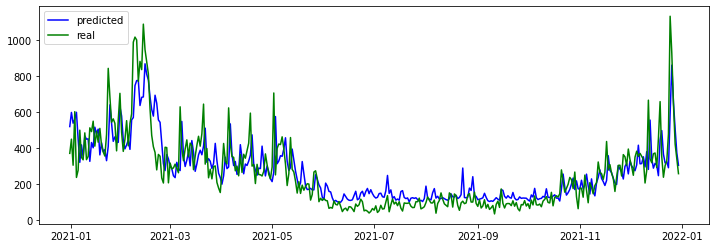

In [78]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

rfr = RandomForestRegressor()
svr = SVR()
lr = LinearRegression()
knn = KNeighborsRegressor()
gpr = GradientBoostingRegressor()
mlpr = MLPRegressor()

models = [rfr,svr,lr,knn,gpr,mlpr]

_n_estimators = 256
_criterion = 'poisson'
_max_depth = 90
_bootstrap = True
_max_features = 'log2'
_min_samples_leaf = 20
_min_samples_split = 9

model = RandomForestRegressor(n_estimators=_n_estimators,
                                  criterion=_criterion,
                                  max_depth=_max_depth,
                                  bootstrap=_bootstrap,
                                  max_features=_max_features,
                                  min_samples_leaf=_min_samples_leaf,
                                  min_samples_split=_min_samples_split,
                                  n_jobs=2)

start_model(model,X_train,y_train,X_test,y_test)

In [69]:
feature_importances = pd.DataFrame(model.feature_importances_, index =X_test.columns,  columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Yesterday,0.439498
Last_Week,0.236472
bike_count,0.119101
temp,0.083341
Yesterday_Diff,0.049136
Last_Year,0.042522
Last_Week_Diff,0.025702
rain,0.003766
Last_Year_Diff,0.000462
snow,0.000000


model = RandomForestRegressor(n_estimators=16,
                              criterion='absolute_error',
                              max_depth=120,
                              bootstrap=False,
                              max_features='log2',
                              min_samples_leaf=6,
                              min_samples_split=30,
                              n_jobs=2)